## Problem2

In [153]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [154]:
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from art.attacks.evasion import CarliniL2Method, SaliencyMapMethod, ElasticNet
from art.estimators.classification import KerasClassifier

# Set the random seeds. Do not change this!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Define some constants.
NUM_CLASSES = 10
BATCH_SIZE = 32

## Part 1

### You need to complete the following.

In [155]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')

# Reshape the data.
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

In [156]:
# Build a training dataset for the substitute model
# Collect ten images from each dataset class (numbers 0-9)
selected_examples = []
for target_label in range(0, 10):
    count = 0
    for i in range(y_train.shape[0]):
        if y_train[i].tolist().index(1) == target_label:
            count += 1
            selected_examples.append((x_train[i, :, :], y_train[i]))
            if count == 10:
                break

# Convert selected examples to numpy array
final_train_x =  np.array( [seq[0] for seq in selected_examples] )
final_train_y =  np.array( [seq[1] for seq in selected_examples] )

In [157]:
# Train a CNN-based substitute model using the newly collected dataset
substitute_model = Sequential()
substitute_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,28,28), data_format='channels_first'))
# Define the intermediate layers.
substitute_model.add(MaxPooling2D((2, 2)))
substitute_model.add(Flatten())
substitute_model.add(Dense(BATCH_SIZE, activation='relu'))

substitute_model.add(Dense(NUM_CLASSES, activation='softmax'))


# Compile the model
substitute_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

substitute_model = KerasClassifier(model=substitute_model, clip_values=(0,1))

# Fit the model
substitute_model.fit(final_train_x, final_train_y, nb_epochs=20, batch_size=BATCH_SIZE)

Epoch 1/20
100/100 [==============================] - 1s 8ms/step - loss: 2.2784 - accuracy: 0.1700
Epoch 2/20
100/100 [==============================] - 0s 2ms/step - loss: 2.1903 - accuracy: 0.2000
Epoch 3/20
100/100 [==============================] - 0s 1ms/step - loss: 2.0284 - accuracy: 0.4900
Epoch 4/20
100/100 [==============================] - 0s 1ms/step - loss: 1.8721 - accuracy: 0.4000
Epoch 5/20
100/100 [==============================] - 0s 2ms/step - loss: 1.6007 - accuracy: 0.5100
Epoch 6/20
100/100 [==============================] - 0s 2ms/step - loss: 1.3678 - accuracy: 0.7600
Epoch 7/20
100/100 [==============================] - 0s 1ms/step - loss: 1.1809 - accuracy: 0.6300
Epoch 8/20
100/100 [==============================] - 0s 1ms/step - loss: 0.9474 - accuracy: 0.8000
Epoch 9/20
100/100 [==============================] - 0s 1ms/step - loss: 0.7123 - accuracy: 0.8300
Epoch 10/20
100/100 [==============================] - 0s 1ms/step - loss: 0.5666 - accuracy: 0.8400

    Please ONLY use the following attack methods.

In [158]:
# Define methods for generating "targetted" adversarial examples
def generate_adv_examples_CarliniL2Method(classifier, x, target_y):
    attacker = CarliniL2Method(classifier,targeted=True)
    attack = attacker.generate(x=x, y=target_y)
    return attack

def generate_adv_examples_ElasticNet(classifier, x, target_y):
    attacker = ElasticNet(classifier,targeted=True)
    attack = attacker.generate(x=x, y=target_y)
    return attack

def generate_adv_examples_SaliencyMapMethod(classifier, x, target_y):
    attacker = SaliencyMapMethod(classifier)
    attack = attacker.generate(x=x, y=target_y)
    return attack

In [159]:
# Build a mapping from the true label to the fake label
# For example, in the mapping below, we want the classifier to predict 0 images as 8.
label_map = {0:8, 1:9, 2:3, 3:5, 4:6, 5:7, 6:4, 7:2, 8:1, 9:0}
for k, v in label_map.items():
    assert(k != v)
assert(len(set(label_map.keys())) == 10)
assert(len(set(label_map.values())) == 10)

# Build target_y
target_y_labels = []
for i in range(final_train_y.shape[0]):
    cur_true_label = final_train_y[i].tolist().index(1)
    target_label = label_map[cur_true_label]
    target_y_labels.append(target_label)
target_y_labels = np.asarray(target_y_labels)
target_y = keras.utils.to_categorical(target_y_labels, NUM_CLASSES)

# Generate 300 adversarial images
carlinil_adv_examples = generate_adv_examples_CarliniL2Method(substitute_model,final_train_x[0:300],target_y[0:300])
elastic_net_adv_examples = generate_adv_examples_ElasticNet(substitute_model,final_train_x[0:300],target_y[0:300])
saliency_adv_examples = generate_adv_examples_SaliencyMapMethod(substitute_model,final_train_x[0:300],target_y[0:300])

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

EAD:   0%|          | 0/100 [00:00<?, ?it/s]

JSMA:   0%|          | 0/100 [00:00<?, ?it/s]

In [160]:
# Calculate Misclassification Ratio (MR) for CarliniL2Method attack
predictions = np.argmax(substitute_model.predict(carlinil_adv_examples),axis=1)
carlinil_mr = (np.sum(predictions == np.argmax(target_y, axis=1))/(predictions.shape[0]))*100
print('For CarliniL2Method attack, MR = {}'.format(carlinil_mr))

# Calculate Misclassification Ratio (MR) for ElasticNet attack
predictions = np.argmax(substitute_model.predict(elastic_net_adv_examples),axis=1)
elastic_net_mr = (np.sum(predictions == np.argmax(target_y, axis=1))/(predictions.shape[0]))*100
print('For ElasticNet attack, MR = {}'.format(elastic_net_mr))

# Calculate Misclassification Ratio (MR) for SaliencyMapMethod attack
predictions = np.argmax(substitute_model.predict(saliency_adv_examples),axis=1)
saliency_mr = (np.sum(predictions == np.argmax(target_y, axis=1))/(predictions.shape[0]))*100
print('For SaliencyMapMethod attack, MR = {}'.format(saliency_mr))

For CarliniL2Method attack, MR = 13.0
For ElasticNet attack, MR = 81.0
For SaliencyMapMethod attack, MR = 100.0


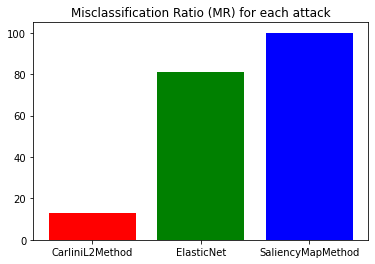

In [161]:
# Make a plot
X = ['CarliniL2Method','ElasticNet', 'SaliencyMapMethod']
mr_arr =[carlinil_mr, elastic_net_mr, saliency_mr]
plt.bar(X, mr_arr ,color=['r', 'g', 'b'])
plt.title('Misclassification Ratio (MR) for each attack')
plt.show()
plt.close()

## Part 2

### You need to complete the following.

In [162]:
# Imports
from numpy import linalg as LA
import pandas as pd

for class_label in range(0, 10):
    print('For images of true class = {}'.format(class_label))
    norms_average = pd.DataFrame([[0,0,0],[0,0,0],[0,0,0]],columns=['carlinil', 'elastic_net', 'saliency'])
    norms_average.index = ['l0','l2','l_inf']
    sum_calc = pd.DataFrame([[0,0,0],[0,0,0],[0,0,0]],columns=['carlinil', 'elastic_net', 'saliency'])
    sum_calc.index = ['l0','l2','l_inf']
    
    for i in range(final_train_y.shape[0]):
        cur_true_label = final_train_y[i].tolist().index(1)
        if cur_true_label == class_label:
            for attack_method in ['carlinil', 'elastic_net', 'saliency']:
                if attack_method == 'carlinil': 
                    sum_calc[attack_method]['l0'] = np.sum(np.abs(final_train_x[i].squeeze()-carlinil_adv_examples[i].squeeze()))
                    sum_calc[attack_method]['l2'] = LA.norm(final_train_x[i].squeeze()-carlinil_adv_examples[i].squeeze(),ord=2)
                    sum_calc[attack_method]['l_inf'] = LA.norm(final_train_x[i].squeeze()-carlinil_adv_examples[i].squeeze(),ord = np.inf)
                elif attack_method == 'elastic_net': 
                    sum_calc[attack_method]['l0'] = np.sum(np.abs(final_train_x[i].squeeze()-elastic_net_adv_examples[i].squeeze()))
                    sum_calc[attack_method]['l2'] = LA.norm(final_train_x[i].squeeze()-elastic_net_adv_examples[i].squeeze(),ord=2)
                    sum_calc[attack_method]['l_inf'] = LA.norm(final_train_x[i].squeeze()-elastic_net_adv_examples[i].squeeze(),ord = np.inf)
                elif attack_method == 'saliency': 
                    sum_calc[attack_method]['l0'] = np.sum(np.abs(final_train_x[i].squeeze()-saliency_adv_examples[i].squeeze()))
                    sum_calc[attack_method]['l2'] = LA.norm(final_train_x[i].squeeze()-saliency_adv_examples[i].squeeze(),ord=2)
                    sum_calc[attack_method]['l_inf'] = LA.norm(final_train_x[i].squeeze()-saliency_adv_examples[i].squeeze(),ord = np.inf)
                #x_diff = (final_train_x[i].squeeze() - cur_adv_examples[i].squeeze()).reshape(-1)
                norms_average[attack_method]['l0'] += sum_calc[attack_method]['l0']
                norms_average[attack_method]['l2'] += sum_calc[attack_method]['l2']
                norms_average[attack_method]['l_inf'] += sum_calc[attack_method]['l_inf']
            
    print('Methods \t L0 \t L2 \t L_inf')
    for attack_method in ['carlinil', 'elastic_net', 'saliency']:
        l0_average = norms_average[attack_method]['l0']/final_train_x.shape[0]
        l2_average = norms_average[attack_method]['l2']/final_train_x.shape[0]
        linf_average = norms_average[attack_method]['l_inf']/final_train_x.shape[0]
        print('{} \t {} \t {} \t {}'.format(attack_method, l0_average, l2_average, linf_average))
    print('\n')


For images of true class = 0
Methods 	 L0 	 L2 	 L_inf
carlinil 	 0.08 	 0.0 	 0.0
elastic_net 	 2.81 	 0.1 	 0.19
saliency 	 0.77 	 0.15 	 0.19


For images of true class = 1
Methods 	 L0 	 L2 	 L_inf
carlinil 	 0.15 	 0.0 	 0.0
elastic_net 	 0.53 	 0.0 	 0.02
saliency 	 0.31 	 0.05 	 0.07


For images of true class = 2
Methods 	 L0 	 L2 	 L_inf
carlinil 	 0.0 	 0.0 	 0.0
elastic_net 	 5.14 	 0.2 	 0.35
saliency 	 1.04 	 0.15 	 0.21


For images of true class = 3
Methods 	 L0 	 L2 	 L_inf
carlinil 	 0.14 	 0.0 	 0.01
elastic_net 	 2.1 	 0.07 	 0.19
saliency 	 0.38 	 0.11 	 0.11


For images of true class = 4
Methods 	 L0 	 L2 	 L_inf
carlinil 	 0.0 	 0.0 	 0.0
elastic_net 	 3.24 	 0.14 	 0.25
saliency 	 0.74 	 0.18 	 0.23


For images of true class = 5
Methods 	 L0 	 L2 	 L_inf
carlinil 	 0.0 	 0.0 	 0.0
elastic_net 	 2.25 	 0.1 	 0.21
saliency 	 0.94 	 0.19 	 0.31


For images of true class = 6
Methods 	 L0 	 L2 	 L_inf
carlinil 	 0.11 	 0.0 	 0.01
elastic_net 	 1.32 	 0.01 	 0.07
sa

## Part 3

### You need to complete the following.

In [163]:
# Imports

# Reload the trained model from HW#3 Problem 4
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle

# Load the pre-trained model.
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    target_net = u.load()

In [164]:
def predict_using_target_net(x, verbose=False):
    x = x.squeeze().reshape(-1, 1)
    outputs = target_net.feedforward(x)
    predictions = np.argmax(outputs)
    if verbose:
        print('Network output: \n' + str(np.round(outputs, 2)) + '\n')
        print('Network prediction: ' + str(predictions) + '\n')
        print('Actual image: ')
    
        # Draw the image
        plt.imshow(x.reshape((28,28)), cmap='Greys')
    return predictions

In [165]:
# Evaluate whether adversarial examples generated with the substitute model will transfer to the target model
for attack_method in ['carlinil', 'elastic_net', 'saliency']:
    pred = None
    miss_cl = None
    it=0
    cnt=0
    if attack_method == 'carlinil':
        for j in carlinil_adv_examples:
            pred = predict_using_target_net(j)
            if(pred==target_y[it].tolist().index(1)):
                cnt+=1
            it+=1
    elif attack_method == 'elastic_net':
        for j in elastic_net_adv_examples:
            pred = predict_using_target_net(j)
            if(pred==target_y[it].tolist().index(1)):
                cnt+=1
            it+=1
    elif attack_method == 'saliency':
        for j in saliency_adv_examples:
            pred = predict_using_target_net(j)
            if(pred==target_y[it].tolist().index(1)):
                cnt+=1
            it+=1
    predictions = pred
    predictions = np.asarray(predictions)
    mr = (cnt/carlinil_adv_examples.shape[0])*100
    print('For {}, Misclassification Ratio = {}'.format(attack_method, mr))

For carlinil, Misclassification Ratio = 4.0
For elastic_net, Misclassification Ratio = 20.0
For saliency, Misclassification Ratio = 14.000000000000002


## Part 4

### You need to complete the following.

In [168]:
# Imports
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [169]:
# Re-load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

nb_trains = x_train.shape[0]
nb_tests = x_test.shape[0]

nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

nsamples_test, nx_test, ny_test = x_test.shape
x_test = x_test.reshape((nsamples_test,nx_test*ny_test))

In [170]:
samp,a,b,c = carlinil_adv_examples.shape
carlinil_adv_examples = carlinil_adv_examples.reshape((samp,a*b*c))
elastic_net_adv_examples = elastic_net_adv_examples.reshape((samp,a*b*c))
saliency_adv_examples = saliency_adv_examples.reshape((samp,a*b*c))

In [126]:
# ANN model
ann_parameters = {
'hidden_layer_sizes': [(100), (100,100)]
}

ann_model = MLPClassifier(max_iter=100)
ann_clf = GridSearchCV(ann_model,ann_parameters)
ann_clf.fit(x_train, y_train)
print("ANN grid search best parameters: {}".format(ann_clf.best_params_))

ANN grid search best parameters: {'hidden_layer_sizes': (100, 100)}


In [127]:
# SVM model
svm_parameters = {
    'kernel': ['rbf'],
    'C': [1, 10]
}

svm_clf = GridSearchCV(SVC(),svm_parameters)
svm_clf.fit(x_train, y_train)
print("SVM grid search best parameters: {}".format(svm_clf.best_params_))

SVM grid search best parameters: {'C': 10, 'kernel': 'rbf'}


In [128]:
# Logistic Regression model
lr_parameters = {
    'multi_class': ['auto'],
    'penalty' : ['l1', 'l2'],
    'C': [1, 10],
}


logreg=LogisticRegression(solver='liblinear')
lr_clf = GridSearchCV(logreg, lr_parameters)
lr_clf.fit(x_train, y_train)
print("Logistic Regression grid search best parameters: {}".format(lr_clf.best_params_))

Logistic Regression grid search best parameters: {'C': 1, 'multi_class': 'auto', 'penalty': 'l1'}


In [129]:
# kNN
knn_parameters = {
    'n_neighbors': [5],
    'weights': ['uniform', 'distance']
}
knn_clf = GridSearchCV(KNeighborsClassifier(n_neighbors=5),knn_parameters)
knn_clf.fit(x_train,y_train)
print("KNN grid search best parameters: {}".format(knn_clf.best_params_))

KNN grid search best parameters: {'n_neighbors': 5, 'weights': 'distance'}


In [130]:
# Naive Bayes
naive_bayes_parameters = {
    'var_smoothing': [1e-3, 1e-2, 1e-1]
}
naive_bayes_clf = GridSearchCV(GaussianNB(),naive_bayes_parameters)
naive_bayes_clf.fit(x_train, y_train)
print("Naive Bayes grid search best parameters: {}".format(naive_bayes_clf.best_params_))

Naive Bayes grid search best parameters: {'var_smoothing': 0.1}


In [131]:
# Voting classifiers
voting_clf = VotingClassifier(estimators=[
                                ('naive_bayes', GaussianNB()),
                                ('ann', MLPClassifier()),
                                ('lr', LogisticRegression()),
                               ], voting='soft')

params = {
          'naive_bayes__var_smoothing': [1e-3, 1e-2, 1e-1],
          'lr__C': [1, 10],
          'ann__hidden_layer_sizes': [(100), (100,100)]}

voting_clf = GridSearchCV(voting_clf, params)
voting_clf.fit(x_train, y_train)
print("Voting Classifier grid search best parameters: {}".format(voting_clf.best_params_))

/Users/chandrikamukherjee/opt/anaconda3/envs/cs529/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/chandrikamukherjee/opt/anaconda3/envs/cs529/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
  

/Users/chandrikamukherjee/opt/anaconda3/envs/cs529/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/chandrikamukherjee/opt/anaconda3/envs/cs529/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
  

/Users/chandrikamukherjee/opt/anaconda3/envs/cs529/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/chandrikamukherjee/opt/anaconda3/envs/cs529/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
  

/Users/chandrikamukherjee/opt/anaconda3/envs/cs529/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/chandrikamukherjee/opt/anaconda3/envs/cs529/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
  

Voting Classifier grid search best parameters: {'ann__hidden_layer_sizes': (100, 100), 'lr__C': 10, 'naive_bayes__var_smoothing': 0.01}


/Users/chandrikamukherjee/opt/anaconda3/envs/cs529/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [197]:
classifier_names = ['ANN', 'SVM', 'Logistic Regression', 'kNN', 'Naive Bayes', 'Voting classifiers']
classifiers = [ann_clf, svm_clf, lr_clf, knn_clf, naive_bayes_clf, voting_clf]
print('Methods \t Test Acc \t Carlinil MR \t ElasticNet MR \t Saliency MR')
for i in range(len(classifiers)):
    test_acc = classifiers[i].score(x_test,y_test)*100
    carlinil_acc = classifiers[i].score(carlinil_adv_examples,target_y_labels)*100
    elasticnet_acc = classifiers[i].score(elastic_net_adv_examples,target_y_labels)*100
    saliency_acc = classifiers[i].score(saliency_adv_examples,target_y_labels)*100
    print('{} \t \t {} \t \t {} \t \t {} \t \t {}'.format(classifier_names[i], str(test_acc), str(carlinil_acc), str(elasticnet_acc), str(saliency_acc)))

Methods 	 Test Acc 	 Carlinil MR 	 ElasticNet MR 	 Saliency MR
ANN 	 	 97.47 	 	 1.0 	 	 15.0 	 	 13.0
SVM 	 	 98.17 	 	 0.0 	 	 9.0 	 	 13.0
Logistic Regression 	 	 92.02 	 	 2.0 	 	 25.0 	 	 26.0
kNN 	 	 96.22 	 	 1.0 	 	 9.0 	 	 2.0
Naive Bayes 	 	 80.73 	 	 7.000000000000001 	 	 25.0 	 	 36.0
Voting classifiers 	 	 94.6 	 	 1.0 	 	 19.0 	 	 24.0


### From the above statistics, we find that the transferability of ElasticNet based adversarial examples is more  
### than Saliency and Carlini based examples in case of ANN, KNN classifiers

### Saliency based adversarial examples is more transferable in SVM, Logistic Regression, Naive Bayes and Voting

### Carlini Adversarial Examples are not much transferable.